# Setting Up Environment and Read Data

In [125]:
## Import the various modules
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection #for plotting purposes

import warnings
warnings.filterwarnings('ignore')

# Data Load

file_name = '/Users/due/Desktop/graphical_analysis/dataset_summary.xlsx'
sheet_name = 'CRSP'
firms_CRSP = pd.read_excel(file_name, sheet_name)
firms_CRSP

,Ticker,Name,Sector,PERMNO
0,FRC,First Republic,Bank,12448
1,PNC,PNC Financial,Bank,60442
2,USB,US Bancorp,Bank,66157
3,JPM,JPMorgan Chase,Bank,47896
4,BAC,Bank of America,Bank,59408
5,C,Citigroup,Bank,70519
6,RY,Royal Bank of Canada,Bank,82654
7,WFC,Wells Fargo,Bank,38703
8,GS,Goldman Sachs,Bank,86868
9,MS,Morgan Stanley,Bank,69032


# Functions Library
This is against good coding etiquette, but a functions library will be included here for an overview. I prefer this in any working document and then having the ability to hiding the cell.

In [164]:
# ############################################################################################################################
# Last Update: July 22nd, 2020
# ############################################################################################################################



# ############################################################################################################################
# IMPORT PACKAGES
# ############################################################################################################################

#import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import matplotlib.pylab as pl #for plotting purposes

import csv
from datetime import datetime, timedelta

from matplotlib.collections import LineCollection #for plotting purposes
from sklearn import cluster, covariance, manifold #for graphical analysis



# ############################################################################################################################
# LOAD DATASETS
# ############################################################################################################################

# Load dataset for Firms Information
file_name = 'CleanedData_Weekly.xlsx'
sheet_name = 'Firms Info'
firms_info = pd.read_excel(file_name, sheet_name, index_col=0)

# Load dataset for T-Bill
df_rf = pd.read_excel('CleanedData_Weekly.xlsx', 'T-Bill', index_col=0)
df_rf.index=pd.to_datetime(df_rf.index)



# ############################################################################################################################
# FUNCTIONS USED FOR GETTING SUMMARY STATISTICS
# ############################################################################################################################

# #############################################################################
# Function used to find the Annualized Sharpe Ratio of x
def sr_annu(x_old,rf_old):
    index = x_old.index[x_old.apply(np.isnan)]
    x = x_old.drop(index).values
    rf = rf_old.drop(index).values
    
    n = len(x)
    ret_expected = np.sum(x-rf)/n
    std_dev = np.sqrt( np.sum( (x-rf - ret_expected)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**52-1
    annu_std_dev = std_dev * np.sqrt(52)
    return annu_ret_expected/annu_std_dev


# #############################################################################
# Function used to find the Maximum drawdown
def mdd(x):
    #x is a return vector
    wealth = (x+1).cumprod()
    #determine cumulative maximum value
    cummax = wealth.cummax()
    #calculate drawdown vector
    drawdown = wealth/cummax - 1
    return drawdown.min()


# #############################################################################
# Function for getting Summary Statistic information, including:
# total returns, average returns, annualized average return, annualized standard deviation,
# annualized sharpe ratio, and maximum drawdown
# NOTE: it will drop the firms that have missing data during the specified time period
def getSumStat(data, rf = df_rf['T-Bill'], rounding = 2):
    
    # Get the Start and End date of the dataset
    date_obj = data.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  data.index[-1].strftime("%m/%d/%Y")
    
    print('Summary Statistic Information from ' + start + ' to ' + end + ':')
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before calculating its summary statistics
    if(data.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(data.columns[data.isna().any()]): print(Xcol_dropped)
        data = data.dropna(axis='columns')
    
    sectors = firms_info.Sector
    ss_temp = pd.DataFrame(sectors, index = data.columns, columns=['Sector'])
    ss_temp['Total Return(%)'] = np.round((((data+1).cumprod()-1)*100).iloc[-1] , rounding)
    ss_temp['Ave Return(%)'] = np.round(data.mean()*100, rounding)
    ss_temp['Annu. Ave Return(%)'] = np.round(((data.mean()+1)**52-1)*100, rounding)
    ss_temp['Annu. Std(%)'] = np.round(data.std()*np.sqrt(52)*100, rounding)
    ss_temp['Annu. Sharpe Ratio'] = np.round(data.apply(sr_annu, rf_old=rf), rounding)
    ss_temp['Max Drawdown(%)'] = np.round(data.apply(mdd)*100, rounding)
    return(ss_temp)



# ############################################################################################################################
# FUNCTIONS USED FOR GRAPHICAL ANALYSIS
# ############################################################################################################################

# Reference: https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

# #############################################################################
# Function for performing graphical network analysis
# Print clusters information, graphical network information, summary statistics, and plot of individual firm performance
# Return correlation and precision matrix, as well as plotting configuration information
# NOTE: it will drop the firms that have missing data during the specified time period

def graphicalAnalysis(dataset, start_date = '2000-01-01', end_date = '2020-05-31', 
                      Sectors_chosen = [],
                      drop_firm = [], 
                      display_SumStat = True, display_IndRet = True, 
                      data_rf = df_rf):
    
    # Check if the inputed date are legit
    if(datetime.strptime(start_date, "%Y-%m-%d") > datetime.strptime(end_date, "%Y-%m-%d")):
        print('ERROR: Revision needed! The entered \"start_date\" should be before \"end_date\".')
        return 0,0
    if (dataset.index[0]- timedelta(days=dataset.index[0].weekday()) > datetime.strptime(start_date, "%Y-%m-%d")):
        print('WARNING: the entered \"start_date\" is outside of the range for the given dataset.')
        print('The \"start_date\" is adjusted to the earliest start_date, i.e. ',
              (dataset.index[0]-timedelta(days=dataset.index[0].weekday())).strftime("%Y-%m-%d"))
        print()
    if (dataset.index[-1] < datetime.strptime(end_date, "%Y-%m-%d")):
        print('WARNING: the entered \"end_date\" is outside of the range for the given dataset.')
        print('The \"end_date\" is adjusted to the lastest end_date, i.e. ',
              dataset.index[-1].strftime("%Y-%m-%d"))
        print()
    
    # Extract the data for the given time period
    temp = dataset[dataset.index >= start_date].copy()
    X = temp[temp.index <= end_date].copy()
    temp = data_rf[data_rf.index >= start_date].copy()
    data_rf2 = temp[temp.index <= end_date].copy()
    
    # Check if we are using all sectors or dropping some sector
    if ((not Sectors_chosen) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_chosen])):
            f_in_sector_chosen = []
            for s in Sectors_chosen:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
            X = X[f_in_sector_chosen]
            print('Sectors choosen in the Graphical Analysis are:')
            print(Sectors_chosen)
            print()
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if we are using all firm or dropping some firms
    if((not drop_firm) == False):
        if(all([(f in X.columns) for f in drop_firm])):
            print('The following Firms are dropped:')
            print(drop_firm)
            print()
            X.drop(columns = drop_firm, inplace = True)
        else:
            print('ERROR: Revision needed! At Least 1 firm entered in the \"drop_firm\" option is NOT in the dataset!')
            print('Check your format!')
            return 0,0
    
    # Check if there is NA in the dataset within the given time period
    # If yes, then drop those firms before doing graphical analysis
    if(X.isnull().values.any()):
        print('WARNING: Some firms have missing data during this time period!')
        print('Dropping firms: ')
        for Xcol_dropped in list(X.columns[X.isna().any()]): print(Xcol_dropped)
        X = X.dropna(axis='columns')
        print()
    
    # Get the Start and End date of the dataset
    date_obj = X.index[0]
    start_of_week = date_obj - timedelta(days=date_obj.weekday())
    start = start_of_week.strftime("%m/%d/%Y")
    end =  X.index[-1].strftime("%m/%d/%Y")
    
    # Get the firm names of the dataset
    names = np.array(list(X.columns))
    
    # Show the number of firms examined
    print('Number of firms examined:', X.shape[1])
    
    
    # #############################################################################
    # Learn a graphical structure from the correlations
    
    # Graphical Lasso is used here to estimate the precision matrix    
    edge_model = covariance.GraphicalLassoCV(max_iter=1000)

    # standardize the time series: 
    # using correlations rather than covariance is more efficient for structure recovery
    X_std = X / X.std(axis=0)
    edge_model.fit(X_std)
    
    # #############################################################################
    # Cluster using affinity propagation

    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    
    for i in range(n_labels + 1):
        print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

    # #############################################################################
    # Find a low-dimension embedding for visualization: find the best position of
    # the nodes (the stocks) on a 2D plane

    node_position_model = manifold.MDS(n_components=2, random_state=0)
    embedding = node_position_model.fit_transform(X_std.T).T

    # #############################################################################
    # Visualization I
    
    # Specify node colors by cluster labels 
    color_list = pl.cm.jet(np.linspace(0,1,n_labels+1))
    my_colors = [color_list[i] for i in labels]
    
    # Compute the partial correlations
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    
    # Compute the edge values based on the partial correlations
    values = np.abs(partial_correlations[non_zero])
    val_max = values.max()
    
    # Title of the plot
    title = 'Graphical Network Analysis of Selected Firms over the Period '+start+' to '+end+' (Weekly)'
    
    # Display the partial correlation graph
    graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title)
    
    # The configuration of the plot
    plot_config = [d, partial_correlations, my_colors, names, labels, embedding, val_max, title]
    
    # #############################################################################
    # Visualization II
    
    # For individual firm performance over the given period
    if (display_IndRet):
        print('Individual Stock Performance over the Period '+ start+' to '+end+' (Weekly):')
        l_r = int(np.ceil(len(names)/4))
        l_c = 4
        f_hei = l_r * 2.5
        f_wid = l_c * 4
        ax = (X+1).cumprod().plot(subplots=True, layout=(l_r, l_c), figsize=(f_wid, f_hei),
                                  logy=True, sharex=True, sharey=True, x_compat=True,
                                  color = my_colors);
        for i in range(l_c):
            ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
        plt.show()

    # #############################################################################
    # Show summary statistics for each firm over the given period
    if (display_SumStat):
        display(getSumStat(X, rf = data_rf2['T-Bill']))
    
    return [edge_model.covariance_, edge_model.precision_], plot_config
# END of function graphicalAnalysis
# #############################################################################


# #############################################################################
# Function Used for plotting the graphical network graph
def graphicalAnalysis_plot(d, partial_correlations, my_colors,
                           names, labels, embedding, val_max, title):
        
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
    n_labels = labels.max()
    
    #For correlation network graph
    fig = plt.figure(1, facecolor='w', figsize=(12, 5))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')

    # Plot the nodes using the coordinates of our embedding
    plt.scatter(embedding[0], embedding[1], s=500 * d ** 2, c= my_colors)

    # Plot the edges
    start_idx, end_idx = np.where(non_zero)
    # a sequence of (*line0*, *line1*, *line2*), where::
    #            linen = (x0, y0), (x1, y1), ... (xm, ym)
    segments = [[embedding[:, start], embedding[:, stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r, 
                        norm=plt.Normalize(0, .7 * val_max))
    lc.set_array(values)
    temp = (15 * values)
    temp2 = np.repeat(5, len(temp))
    w = np.minimum(temp, temp2)
    lc.set_linewidths(w)
    ax.add_collection(lc)
    axcb = fig.colorbar(lc)
    axcb.set_label('Strength')

    # Add a label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    for index, (name, label, (x, y)) in enumerate(
            zip(names, labels, embedding.T)):

        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .002
        else:
            horizontalalignment = 'right'
            x = x - .002
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .002
        else:
            verticalalignment = 'top'
            y = y - .002
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                           alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    plt.title(title)
    plt.show()
# END of function graphicalAnalysis_plot
# #############################################################################


# #############################################################################
# Function Used for plotting the graphical network graph for the specified sectors
# Can be used to see more details of the network graph
def graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, plot_config):
    
    d = plot_config[0]
    pc = plot_config[1]
    my_colors = np.array(plot_config[2])
    names = plot_config[3]
    labels = plot_config[4]
    embedding = plot_config[5]
    val_max = plot_config[6]
    title = 'ZOOM IN VIEW: ' + plot_config[7]
    
    if ((not Sectors_list) == False):
        if(all([(s in firms_info.Sector.unique()) for s in Sectors_list])):
            f_in_sector_chosen = []
            for s in Sectors_list:
                f_in_sector_chosen += list(firms_info[firms_info.Sector == s].index)
        else:
            print('ERROR: Revision needed! At Least 1 Sector entered in the \"Sectors_choosen\" option is NOT in the dataset!')
            print('Check your format!')
    else:
        print('Error: Need to enter the sectors you wanted to examine in the \"Sectors_list\" option!')
        return
    
    f_selected = list(set(f_in_sector_chosen).intersection(set(names)))
            
    if(not f_selected):
        print('ERROR: Revision needed! No firms in the selected sectors!')
        print('Check your format!')
        print('Note that the sectors entered in the \"Sectors_list\" option should also be in the \"Sectors_choosen\" option!')
        return
    else:
        ind = np.array([np.where(names == i)[0][0] for i in f_selected])

    graphicalAnalysis_plot(d[ind], pc[ind[:, None], ind], my_colors[ind],
                           names[ind], labels[ind], embedding[:,ind], val_max, title)
# END of function graphicalAnalysis_plot_ZOOM_bySector
# #############################################################################


# #############################################################################
# Function Used for plotting the graphical network graph for the specified firms
# Can be used to see more details of the network graph
def graphicalAnalysis_plot_ZOOM_byFirm(firms_list, plot_config):
    
    d = plot_config[0]
    pc = plot_config[1]
    my_colors = np.array(plot_config[2])
    names = plot_config[3]
    labels = plot_config[4]
    embedding = plot_config[5]
    val_max = plot_config[6]
    title = 'ZOOM IN VIEW: ' + plot_config[7]
    
    if( all([(f in names) for f in firms_list]) ):
        if (not firms_list):
            print('Error: Need to enter the firms you wanted to examine in the \"firms_list\" option!')
            return
        else:
            ind = np.array([np.where(names == i)[0][0] for i in firms_list])
    else:
        print('Error: Revision needed! At Least 1 firm entered in the \"firms_list\" are NOT in the dataset!')
        print('Check your format and also whether the firms are dropped due to missing data!')
        return

    graphicalAnalysis_plot(d[ind], pc[ind[:, None], ind], my_colors[ind],
                           names[ind], labels[ind], embedding[:,ind], val_max, title)
# END of function graphicalAnalysis_plot_ZOOM_byFirm
# #############################################################################


In [60]:
## Read the daily dataset (this dataset file is downloaded from CRSP)
file_name = '/Users/due/Desktop/graphical_analysis/dataset_CRSP_daily.csv'
df = pd.read_csv(file_name,low_memory=False)
df

,PERMNO,date,TICKER,COMNAM,CUSIP,RET
0,10107,1999/12/31,MSFT,MICROSOFT CORP,59491810,-0.007439
1,10107,2000/01/03,MSFT,MICROSOFT CORP,59491810,-0.001606
2,10107,2000/01/04,MSFT,MICROSOFT CORP,59491810,-0.033780
3,10107,2000/01/05,MSFT,MICROSOFT CORP,59491810,0.010544
4,10107,2000/01/06,MSFT,MICROSOFT CORP,59491810,-0.033498
...,...,...,...,...,...,...
104436,90794,2020/06/24,RDS,ROYAL DUTCH SHELL PLC,78025920,-0.049641
104437,90794,2020/06/25,RDS,ROYAL DUTCH SHELL PLC,78025920,0.023249
104438,90794,2020/06/26,RDS,ROYAL DUTCH SHELL PLC,78025920,-0.028917
104439,90794,2020/06/29,RDS,ROYAL DUTCH SHELL PLC,78025920,0.016104


In [62]:
## Check the column names of the dataset
df.columns

Index(['PERMNO', 'date', 'TICKER', 'COMNAM', 'CUSIP', 'RET'], dtype='object')

In [64]:
## Check the unique tickers in the dataset
# Note that there is more tickers than the ones we specified in the summary information
df.TICKER.unique()

array(['MSFT', 'XOM', 'FRC', 'CHV', 'CVX', 'AAPL', 'BABA', 'PFE', 'JNJ',
       'MRK', 'BPA', 'BP', 'WFC', 'CMB', 'JPM', 'BAC', 'PNC', 'USB',
       'MWD', 'MS', 'C', 'RY', 'GS', 'HBC', 'HSBC', 'GOOG', 'GOOGL',
       'RDS'], dtype=object)

# Data Cleaning

In [67]:
## Rearrange the data: separate by the specified tickers and extract "RET" column only
RET_DFS = []
for i in range(len(firms_CRSP.PERMNO)):
    temp = firms_CRSP.PERMNO[i]
    firmTic = firms_CRSP.Ticker[i]
    df_temp = df[df.PERMNO == temp].copy()
    df_temp['date']=pd.to_datetime(df_temp['date'])

    RET_data=pd.DataFrame(columns=['RET'], index=df_temp.date)
    RET_data['RET']=pd.to_numeric(df_temp['RET'].values, errors='coerce')
    RET_DFS.append(RET_data)
    
    # Output the firm (ticker) and its shape
    print(firmTic,':', RET_data.shape)

FRC : (2405, 1)
PNC : (5157, 1)
USB : (5157, 1)
JPM : (5157, 1)
BAC : (5157, 1)
C : (5157, 1)
RY : (5157, 1)
WFC : (5157, 1)
GS : (5157, 1)
MS : (5158, 1)
HSBC : (5157, 1)
JNJ : (5157, 1)
PFE : (5157, 1)
MRK : (5157, 1)
XOM : (5157, 1)
RDS : (3760, 1)
CVS : (5157, 1)
BP : (5157, 1)
AAPL : (5157, 1)
GOOG : (3994, 1)
MSFT : (5157, 1)
BABA : (1455, 1)


In [69]:
## Put the return data together

len_RET_DFS = np.array([len(temp) for temp in RET_DFS])

Names = firms_CRSP.Ticker
data = pd.DataFrame(columns=Names, index=RET_DFS[np.argmax(len_RET_DFS)].index)
for i in range(len(Names)):
    data[Names[i]] = RET_DFS[i]

In [71]:
data

Ticker,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,PFE,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA
date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,-0.005587,0.005277,-0.004804,-0.009864,0.006780,0.001418,-0.004615,0.021695,0.010619,...,-0.007648,-0.009217,0.001554,NaN,0.013158,-0.003151,0.024922,NaN,-0.007439,NaN
2000-01-03,NaN,-0.051966,-0.065617,-0.060338,-0.034869,-0.050505,-0.031161,-0.032457,-0.062376,-0.054291,...,-0.017341,0.006512,-0.029480,NaN,-0.034632,-0.008430,0.088754,NaN,-0.001606,NaN
2000-01-04,NaN,-0.031111,-0.033708,-0.023493,-0.059355,-0.042553,-0.001462,-0.051118,-0.062987,-0.074074,...,-0.037255,-0.037893,-0.017586,NaN,0.000000,-0.005313,-0.084310,NaN,-0.033780,NaN
2000-01-05,NaN,0.004587,-0.002907,-0.006173,0.010974,0.003704,-0.005857,-0.008418,-0.046828,-0.036500,...,0.016293,0.042267,0.054516,NaN,0.017937,0.034188,0.014634,NaN,0.010544,NaN
2000-01-06,NaN,0.047184,0.032070,0.014197,0.071913,0.065191,0.008837,0.044143,0.042789,0.019201,...,0.036072,0.008295,0.049383,NaN,0.042584,0.002066,-0.086538,NaN,-0.033498,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,-0.026556,-0.040379,-0.044819,-0.033391,-0.039532,-0.040415,-0.015222,-0.040764,-0.033011,-0.019628,...,-0.017699,-0.016209,-0.047109,-0.049641,-0.041557,-0.042615,-0.017652,-0.021366,-0.020158,-0.011060
2020-06-25,0.024723,0.029696,0.032004,0.034862,0.038219,0.036804,0.014863,0.047856,0.045854,0.039191,...,0.004039,0.009226,0.015056,0.023249,0.017914,0.015558,0.013276,0.005863,0.012636,-0.017947
2020-06-26,-0.040303,-0.051855,-0.052300,-0.054818,-0.063511,-0.058846,-0.023433,-0.074169,-0.086480,-0.035663,...,-0.008663,-0.018023,-0.034315,-0.028917,-0.030826,-0.031489,-0.030726,-0.054514,-0.020016,-0.029033


### S&P 500 data

We will add in the S&P500 dataset (downloaded from CRSP) to our daily return data here. 

In [74]:
## Read CRSP SP500 dataset
file_name = '/Users/due/Desktop/graphical_analysis/SP500_CRSP_daily.csv'
df2 = pd.read_csv(file_name,low_memory=False)
df2['date']=pd.to_datetime(df2['caldt'])

SP500_data=pd.DataFrame(columns=['SP500'], index=df2.date)
SP500_data['SP500']=pd.to_numeric(df2['sprtrn'].values, errors='coerce')

# Add the S&P500 return data to our stock returns dataframe
data = data.join(SP500_data)

In [76]:
data

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,-0.005587,0.005277,-0.004804,-0.009864,0.006780,0.001418,-0.004615,0.021695,0.010619,...,-0.009217,0.001554,NaN,0.013158,-0.003151,0.024922,NaN,-0.007439,NaN,NaN
2000-01-03,NaN,-0.051966,-0.065617,-0.060338,-0.034869,-0.050505,-0.031161,-0.032457,-0.062376,-0.054291,...,0.006512,-0.029480,NaN,-0.034632,-0.008430,0.088754,NaN,-0.001606,NaN,-0.009549
2000-01-04,NaN,-0.031111,-0.033708,-0.023493,-0.059355,-0.042553,-0.001462,-0.051118,-0.062987,-0.074074,...,-0.037893,-0.017586,NaN,0.000000,-0.005313,-0.084310,NaN,-0.033780,NaN,-0.038345
2000-01-05,NaN,0.004587,-0.002907,-0.006173,0.010974,0.003704,-0.005857,-0.008418,-0.046828,-0.036500,...,0.042267,0.054516,NaN,0.017937,0.034188,0.014634,NaN,0.010544,NaN,0.001922
2000-01-06,NaN,0.047184,0.032070,0.014197,0.071913,0.065191,0.008837,0.044143,0.042789,0.019201,...,0.008295,0.049383,NaN,0.042584,0.002066,-0.086538,NaN,-0.033498,NaN,0.000956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,-0.026556,-0.040379,-0.044819,-0.033391,-0.039532,-0.040415,-0.015222,-0.040764,-0.033011,-0.019628,...,-0.016209,-0.047109,-0.049641,-0.041557,-0.042615,-0.017652,-0.021366,-0.020158,-0.011060,-0.025855
2020-06-25,0.024723,0.029696,0.032004,0.034862,0.038219,0.036804,0.014863,0.047856,0.045854,0.039191,...,0.009226,0.015056,0.023249,0.017914,0.015558,0.013276,0.005863,0.012636,-0.017947,0.010959
2020-06-26,-0.040303,-0.051855,-0.052300,-0.054818,-0.063511,-0.058846,-0.023433,-0.074169,-0.086480,-0.035663,...,-0.018023,-0.034315,-0.028917,-0.030826,-0.031489,-0.030726,-0.054514,-0.020016,-0.029033,-0.024227


In [78]:
#Converting data from daily to weekly
## Reorganize the data and convert it to weekly frequency

WEEKLY_DFS = []

for i in range(len(data.columns)):
    firm = data.columns[i]
    RET = data[firm].dropna(axis=0)
    RET_weekly = (RET+1).resample('W').prod() - 1 # Convert daily data to weekly
    WEEKLY_DFS.append(RET_weekly)

len_WEEKLY_DFS = np.array([len(temp) for temp in WEEKLY_DFS])
Names = data.columns
data_weekly = pd.DataFrame(columns=Names, index=WEEKLY_DFS[np.argmax(len_WEEKLY_DFS)].index)
for i in range(len(Names)):
    data_weekly[Names[i]] = WEEKLY_DFS[i]

In [79]:
data_weekly

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,NaN,-0.005587,0.005277,-0.004804,-0.009864,0.006780,0.001418,-0.004615,0.021695,0.010619,...,-0.009217,0.001554,NaN,0.013158,-0.003151,0.024922,NaN,-0.007439,NaN,NaN
2000-01-09,NaN,-0.032304,-0.049869,-0.058139,-0.029888,-0.030302,-0.042493,-0.032457,-0.123426,-0.113398,...,0.115349,0.054307,NaN,0.042568,0.003161,-0.032218,NaN,-0.045503,NaN,-0.018908
2000-01-16,NaN,0.097264,0.019338,0.015465,0.034659,0.074074,-0.017752,0.065494,0.037093,0.088261,...,-0.010843,-0.013980,NaN,-0.036678,-0.070379,0.009422,NaN,0.007291,NaN,0.016428
2000-01-23,NaN,-0.061498,-0.094850,-0.012690,-0.093051,-0.026939,-0.035181,-0.121438,0.002128,-0.035047,...,-0.022765,0.014925,NaN,0.017960,0.016948,0.108278,NaN,-0.075724,NaN,-0.016237
2000-01-30,NaN,0.045583,0.005989,0.051414,0.001367,-0.005537,0.068037,0.058020,0.015318,-0.044340,...,0.054358,-0.072060,NaN,-0.067749,-0.041110,-0.087029,NaN,-0.053012,NaN,-0.056336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555,0.058633,0.049147
2020-06-14,-0.111648,-0.134890,-0.114703,-0.102130,-0.118463,-0.112299,-0.064237,-0.116829,-0.074064,-0.065617,...,-0.065038,-0.111341,-0.087901,-0.083523,-0.106819,0.022022,-0.018820,0.002886,-0.008699,-0.047783
2020-06-21,0.038987,-0.022843,0.036257,-0.020626,0.018967,0.012823,0.010253,-0.013228,-0.000744,0.014045,...,0.020968,-0.025229,-0.014805,-0.019048,-0.043636,0.032230,0.008295,0.039468,0.013785,0.018554


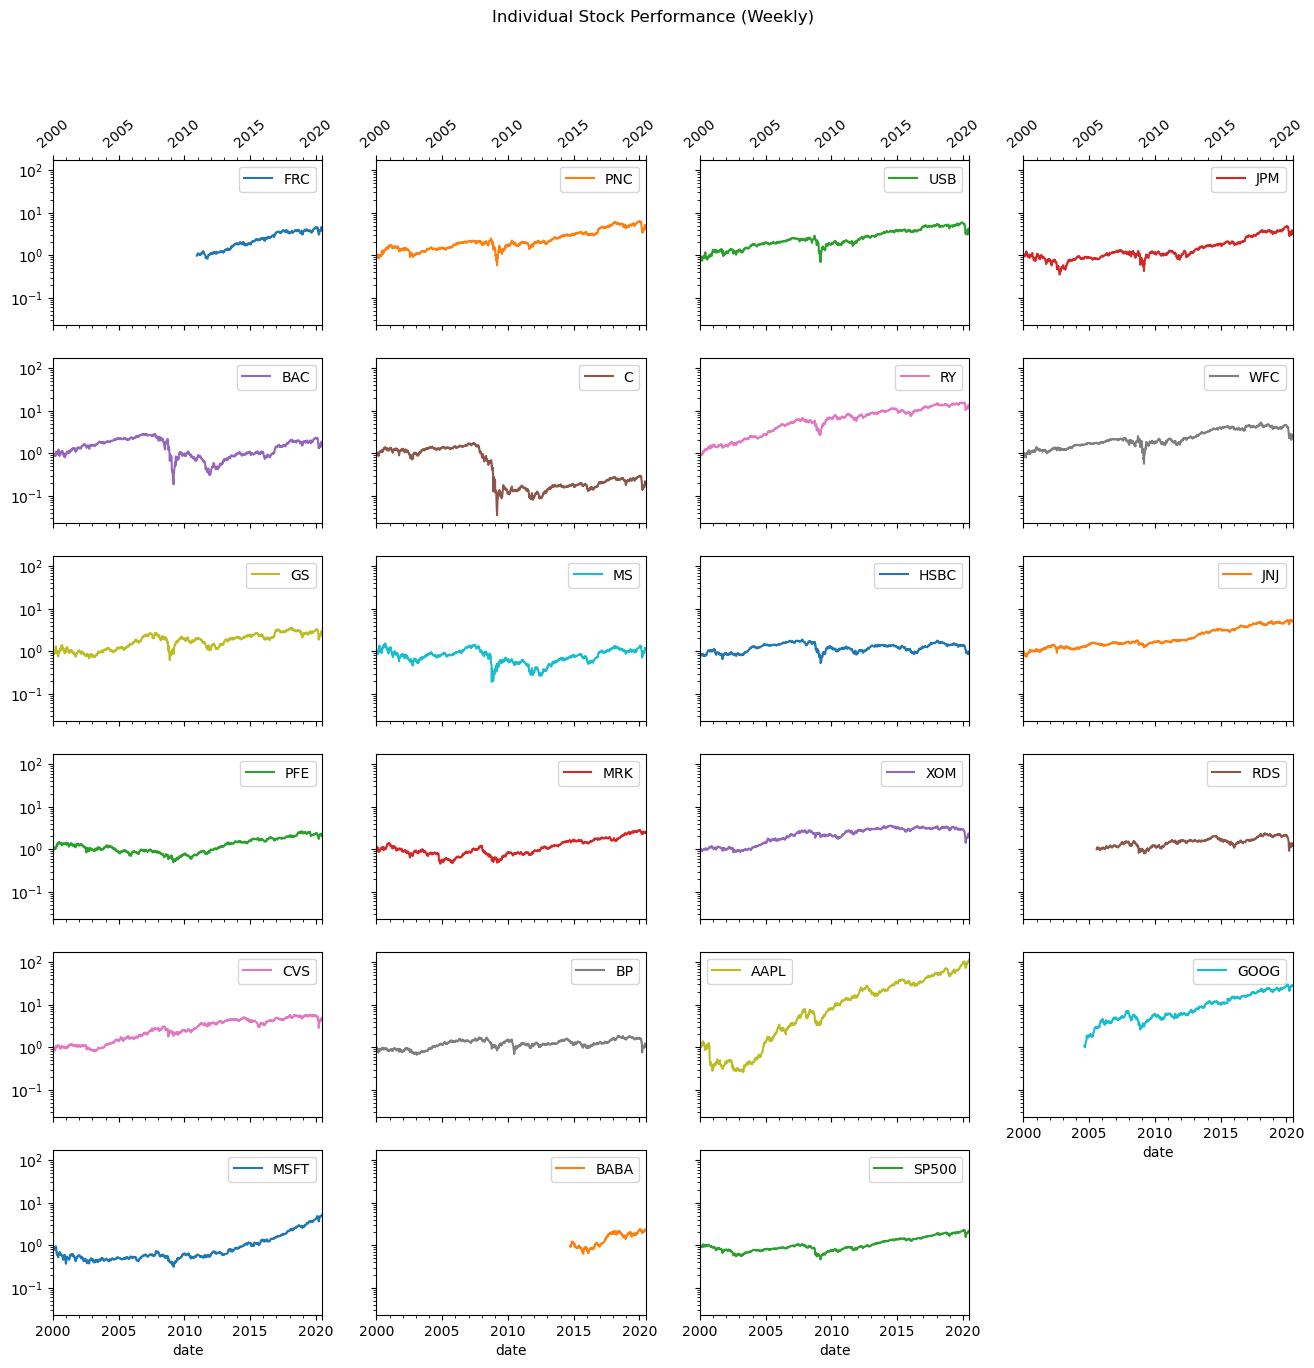

In [80]:
## Plot the individual stock performance (or cumulative return)

col = 4
row = int(np.ceil(len(Names)/col))
f_hei = row * 2.5
f_wid = col * 4
ax = (data_weekly+1).cumprod().plot(subplots=True, layout=(row, col), figsize=(f_wid, f_hei),
                                    logy=True, sharey=True, sharex=True, 
                                    title = 'Individual Stock Performance (Weekly)')
for i in range(col):
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
plt.show()

# Read and Edit Rate Data
Data Source for weekly T-Bill return: https://fred.stlouisfed.org/series/WTB3MS#0
Data downloaded from FRED has unit in percentage, and it is percent per annum. Moreover, although it is weekly data, it ends on every Friday, yet the weekly return data above is ending on Sunday. So we need to edit its format.

In [84]:
## Read and Edit data into the right format
file_name = '/Users/due/Desktop/graphical_analysis/WTB3MS.csv'
df = pd.read_csv(file_name)

df['DATE']=pd.to_datetime(df['DATE'])
df['WTB3MS'] = pd.to_numeric(df['WTB3MS'], errors='coerce')

RET_data=pd.DataFrame(columns=['RET'], index=df.DATE)
RET_data['RET'] = (df['WTB3MS'].values/100 + 1) ** (1/52) - 1 # Edit the unit of the return data

RET_data_weekly = (RET_data['RET']+1).resample('W').prod() - 1 # Convert the data to the same weekly frequency as above
TBill = pd.DataFrame(columns=['T-Bill'], index=RET_data_weekly.index)
TBill['T-Bill'] = RET_data_weekly

TBill

,T-Bill
DATE,
1954-01-10,0.000248
1954-01-17,0.000245
1954-01-24,0.000212
1954-01-31,0.000193
1954-02-07,0.000189
...,...
2020-05-31,0.000029
2020-06-07,0.000029
2020-06-14,0.000033


In [85]:
## Firm Info

firms_CRSP.drop(columns = 'PERMNO', inplace = True) # Dropping the PERMNO column
firms_CRSP = firms_CRSP.set_index('Ticker') # Set Ticker as the index of the dataframe
firms_CRSP

,Name,Sector
Ticker,,
FRC,First Republic,Bank
PNC,PNC Financial,Bank
USB,US Bancorp,Bank
JPM,JPMorgan Chase,Bank
BAC,Bank of America,Bank
C,Citigroup,Bank
RY,Royal Bank of Canada,Bank
WFC,Wells Fargo,Bank
GS,Goldman Sachs,Bank


In [100]:
## Adding S&P500 information to Firm Info
# NOTE: one can skip this block if S&P500 is not added to the dataframe!!
df2 = pd.DataFrame({'Ticker': ['SP500'], 'Name': ['S&P 500'], 'Sector': ['Market Index']})
df2 = df2.set_index('Ticker')

# Use pd.concat to add df2 to firms_CRSP
firms_CRSP = pd.concat([firms_CRSP, df2], sort=False)
firms_CRSP


,Name,Sector
Ticker,,
FRC,First Republic,Bank
PNC,PNC Financial,Bank
USB,US Bancorp,Bank
JPM,JPMorgan Chase,Bank
BAC,Bank of America,Bank
C,Citigroup,Bank
RY,Royal Bank of Canada,Bank
WFC,Wells Fargo,Bank
GS,Goldman Sachs,Bank


In [102]:
## Stock Returns Data

#Dropping the first row since it only has one day (1999-12-31) of return for the first week 
data_weekly.drop(data_weekly.index[0], inplace = True)
#Dropping the last row since it only has two days (2020-06-29,2020-06-30) of return rather than a whole-week return 
data_weekly.drop(data_weekly.index[-1], inplace = True)
data_weekly

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
2000-01-16,NaN,0.097264,0.019338,0.015465,0.034659,0.074074,-0.017752,0.065494,0.037093,0.088261,...,-0.010843,-0.013980,NaN,-0.036678,-0.070379,0.009422,NaN,0.007291,NaN,0.016428
2000-01-23,NaN,-0.061498,-0.094850,-0.012690,-0.093051,-0.026939,-0.035181,-0.121438,0.002128,-0.035047,...,-0.022765,0.014925,NaN,0.017960,0.016948,0.108278,NaN,-0.075724,NaN,-0.016237
2000-01-30,NaN,0.045583,0.005989,0.051414,0.001367,-0.005537,0.068037,0.058020,0.015318,-0.044340,...,0.054358,-0.072060,NaN,-0.067749,-0.041110,-0.087029,NaN,-0.053012,NaN,-0.056336
2000-02-06,NaN,-0.028609,0.014881,0.066015,-0.008197,-0.021727,-0.054815,0.000774,-0.026581,0.037512,...,-0.017185,0.025358,NaN,-0.048448,-0.086906,0.062731,NaN,0.084604,NaN,0.047208
2000-02-13,NaN,-0.054699,-0.064517,0.010705,-0.004131,-0.013698,0.018809,-0.017828,0.005166,0.016176,...,-0.130725,-0.081269,NaN,-0.058074,-0.053299,0.006943,NaN,-0.062169,NaN,-0.026151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-24,0.014493,0.075682,0.073337,0.041561,0.056902,0.052004,0.002213,0.034675,0.046897,0.076159,...,-0.042742,0.061905,0.070030,0.026675,0.053162,0.036333,0.029263,0.004663,-0.019540,0.032039
2020-05-31,0.111717,0.090144,0.079866,0.087626,0.064430,0.086395,0.101580,0.095159,0.098984,0.101420,...,0.056960,0.019506,-0.008995,0.015730,0.006964,-0.002980,0.014351,-0.001417,0.038508,0.030066
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555,0.058633,0.049147


In [104]:
## T-Bill Return Data

start_date = data_weekly.index[0]
end_date = data_weekly.index[-1]
TBill = TBill[TBill.index >= start_date] # To match the start date of the Stock Return data
TBill = TBill[TBill.index <= end_date]   # To match the end date of the Stock Return data
TBill

,T-Bill
DATE,
2000-01-16,0.000986
2000-01-23,0.000995
2000-01-30,0.001014
2000-02-06,0.001030
2000-02-13,0.001028
...,...
2020-05-24,0.000023
2020-05-31,0.000029
2020-06-07,0.000029


In [122]:
# Save data as Excel file with multiple sheets
with pd.ExcelWriter('CleanedData_Weekly.xlsx', engine='xlsxwriter') as writer:
    firms_CRSP.to_excel(writer, sheet_name='Firms Info')
    data_weekly.to_excel(writer, sheet_name='Stock Returns')
    TBill.to_excel(writer, sheet_name='T-Bill')

# Analysis

In [129]:
firms_info

,Name,Sector
Ticker,,
FRC,First Republic,Bank
PNC,PNC Financial,Bank
USB,US Bancorp,Bank
JPM,JPMorgan Chase,Bank
BAC,Bank of America,Bank
C,Citigroup,Bank
RY,Royal Bank of Canada,Bank
WFC,Wells Fargo,Bank
GS,Goldman Sachs,Bank


In [131]:
# Get and print the Sector Information
Sectors = firms_info.Sector.unique()
print(Sectors)

['Bank' 'Health' 'Energy' 'Tech' 'Market Index']


In [133]:
# Load Stock Return dataset 
file_name = '/Users/due/Desktop/graphical_analysis/CleanedData_Weekly.xlsx'
sheet_name = 'Stock Returns'
df = pd.read_excel(file_name, sheet_name, index_col=0)
df.index=pd.to_datetime(df.index)    
data = df.copy()

In [135]:
data

,FRC,PNC,USB,JPM,BAC,C,RY,WFC,GS,MS,...,MRK,XOM,RDS,CVS,BP,AAPL,GOOG,MSFT,BABA,SP500
date,,,,,,,,,,,,,,,,,,,,,
2000-01-09,NaN,-0.032304,-0.049869,-0.058139,-0.029888,-0.030302,-0.042493,-0.032457,-0.123426,-0.113398,...,0.115349,0.054307,NaN,0.042568,0.003161,-0.032218,NaN,-0.045503,NaN,-0.018908
2000-01-16,NaN,0.097264,0.019338,0.015465,0.034659,0.074074,-0.017752,0.065494,0.037093,0.088261,...,-0.010843,-0.013980,NaN,-0.036678,-0.070379,0.009422,NaN,0.007291,NaN,0.016428
2000-01-23,NaN,-0.061498,-0.094850,-0.012690,-0.093051,-0.026939,-0.035181,-0.121438,0.002128,-0.035047,...,-0.022765,0.014925,NaN,0.017960,0.016948,0.108278,NaN,-0.075724,NaN,-0.016237
2000-01-30,NaN,0.045583,0.005989,0.051414,0.001367,-0.005537,0.068037,0.058020,0.015318,-0.044340,...,0.054358,-0.072060,NaN,-0.067749,-0.041110,-0.087029,NaN,-0.053012,NaN,-0.056336
2000-02-06,NaN,-0.028609,0.014881,0.066015,-0.008197,-0.021727,-0.054815,0.000774,-0.026581,0.037512,...,-0.017185,0.025358,NaN,-0.048448,-0.086906,0.062731,NaN,0.084604,NaN,0.047208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,0.111717,0.090144,0.079866,0.087626,0.064430,0.086395,0.101580,0.095159,0.098984,0.101420,...,0.056960,0.019506,-0.008995,0.015730,0.006964,-0.002980,0.014351,-0.001417,0.038508,0.030066
2020-06-07,0.110382,0.122675,0.191507,0.143049,0.173256,0.228554,0.109022,0.196449,0.109063,0.120588,...,0.019078,0.167364,0.182160,0.099345,0.197494,0.042649,0.004535,0.021555,0.058633,0.049147
2020-06-14,-0.111648,-0.134890,-0.114703,-0.102130,-0.118463,-0.112299,-0.064237,-0.116829,-0.074064,-0.065617,...,-0.065038,-0.111341,-0.087901,-0.083523,-0.106819,0.022022,-0.018820,0.002886,-0.008699,-0.047783


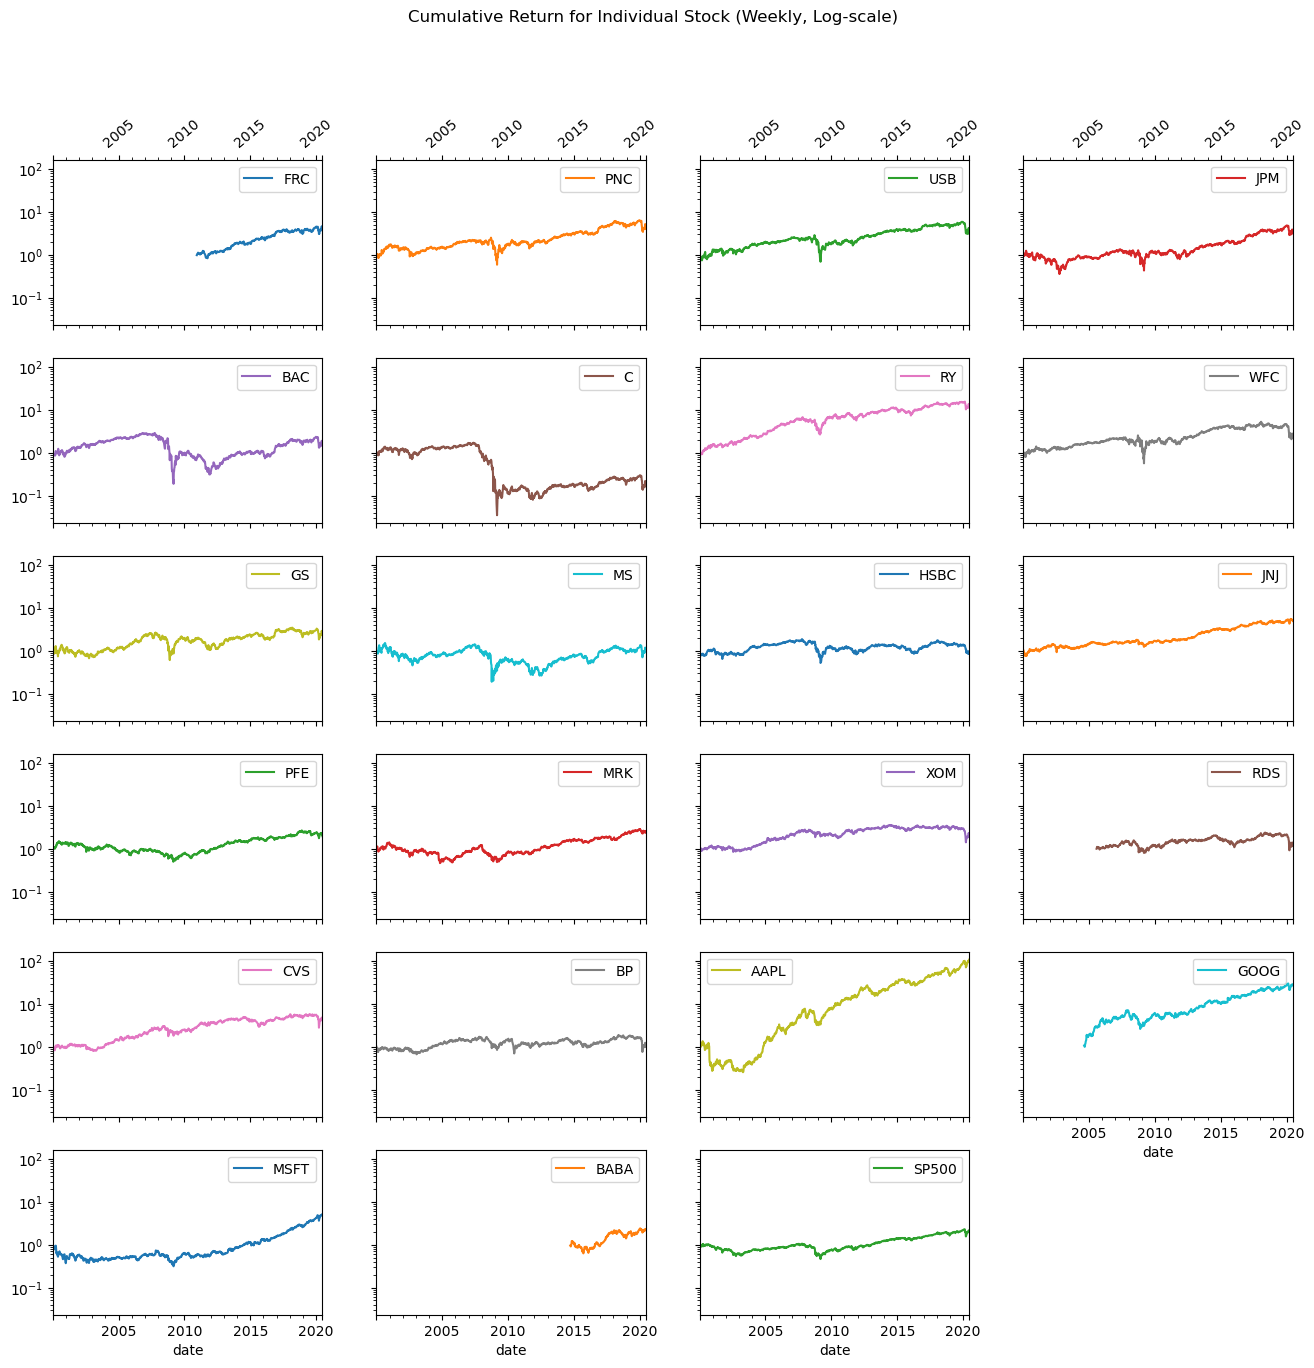

# Graphical Analysis
This graphical analysis algorithm applies sparse inverse covariance estimation, affinity propagation clustering, and manifold learning (using multidimensional scaling) to weekly stock returns data, combining these techniques to construct and visualize a high-dimensional graph of stock correlations and clusters.

In [145]:
print(Sectors)

['Bank' 'Health' 'Energy' 'Tech' 'Market Index']


# Data Analysis
The specifications allow users to define a date range, include specific sectors or exclude certain firms for graphical analysis, and by default display summary statistics and individual firm performance unless specified otherwise.

In [148]:
## Start and End date we are considering:
start_date = '2020-01-01'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank','Health','Energy','Tech']

## The list of firms we want to drop:
drop_firm = []

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = True
display_IndRet = True

In [170]:
def sr_annu(x_old, rf_old):
    # Align the indices of x_old and rf_old
    aligned_data = pd.concat([x_old, rf_old], axis=1, join='inner', keys=['x', 'rf']).dropna()
    x = aligned_data['x'].values
    rf = aligned_data['rf'].values

    n = len(x)
    ret_expected = np.sum(x - rf) / n
    std_dev = np.sqrt(np.sum((x - rf - ret_expected) ** 2) / n)
    annu_ret_expected = (ret_expected + 1) ** 52 - 1
    annu_std_dev = std_dev * np.sqrt(52)
    return annu_ret_expected / annu_std_dev


Results over the time period  2020-01-01  to  2020-06-28 :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Number of firms examined: 22
Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL, GOOG, MSFT
Cluster 5: BABA


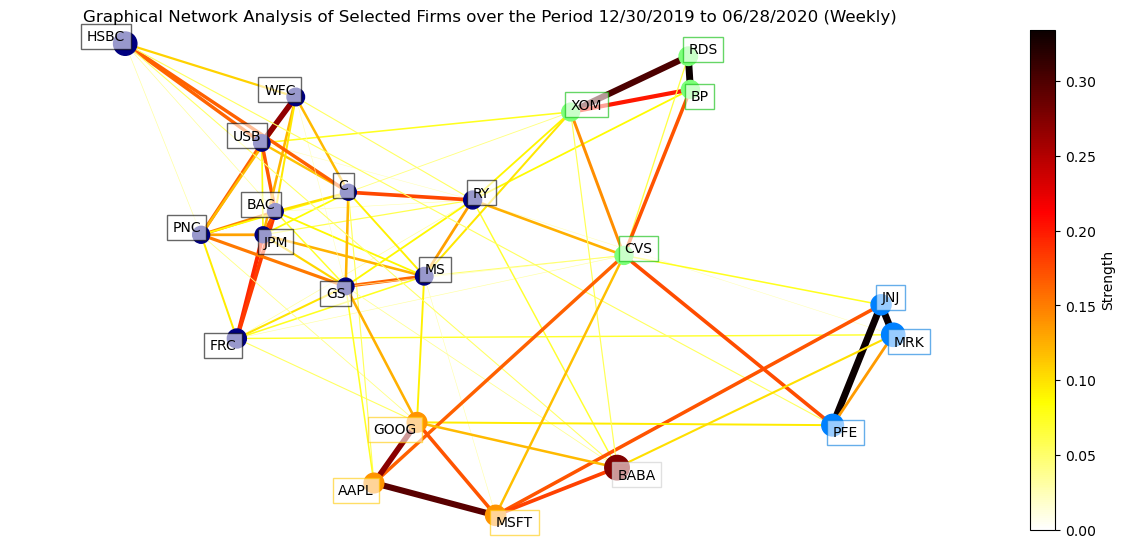

Individual Stock Performance over the Period 12/30/2019 to 06/28/2020 (Weekly):


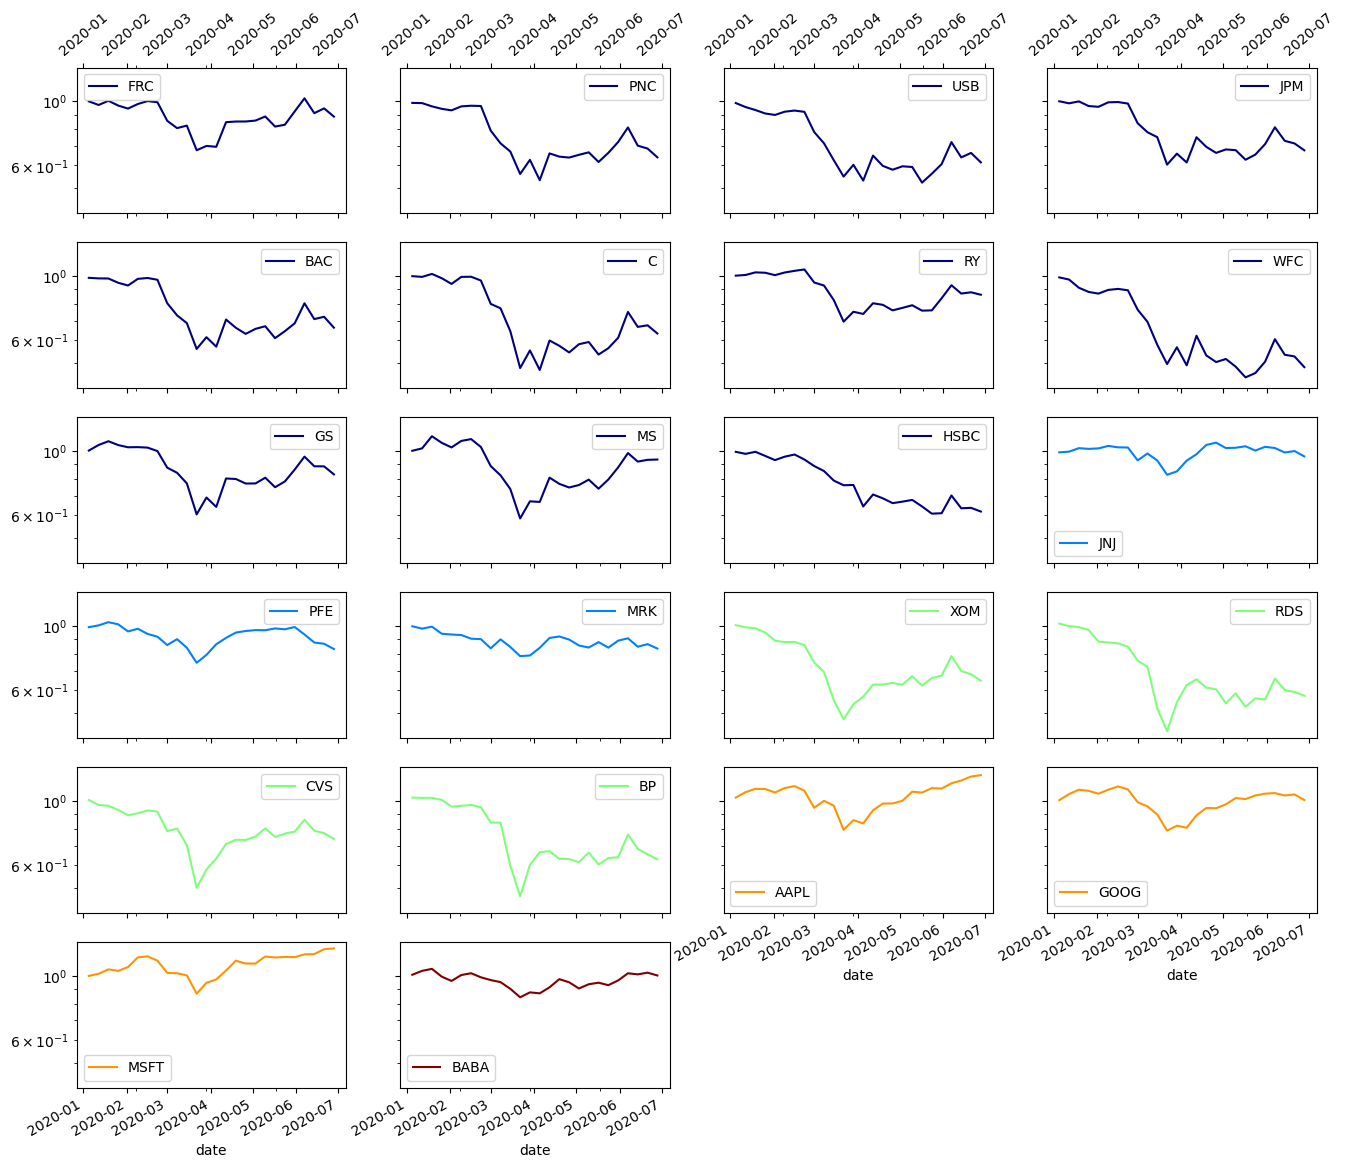

Summary Statistic Information from 12/30/2019 to 06/28/2020:


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
FRC,Bank,-11.45,-0.16,-8.11,57.39,0.07,-32.56
PNC,Bank,-35.98,-1.27,-48.68,67.95,-0.63,-45.96
USB,Bank,-38.49,-1.44,-52.93,67.65,-0.70,-46.95
JPM,Bank,-32.30,-1.13,-44.75,62.17,-0.65,-39.64
BAC,Bank,-33.63,-1.14,-44.79,68.50,-0.54,-43.26
C,Bank,-36.64,-1.09,-43.39,83.90,-0.45,-53.47
RY,Bank,-13.72,-0.38,-17.95,44.40,-0.36,-34.02
WFC,Bank,-51.54,-2.22,-68.89,76.84,-0.85,-54.91
GS,Bank,-16.94,-0.32,-15.13,65.86,-0.07,-44.17
MS,Bank,-6.51,0.15,8.25,66.58,0.11,-48.07


In [172]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()

# Output the Clustering information, graphical network plot, 
# as well as summary statistics (optional) and the individual firm performance (optional)
# Store the correlation matrix and precision matrix in "est" (stands for estimates)
# Store the plotting configuration information in "con_fig" which will be needed if we want to use the ZOOM functions
## Note: you can view the correlation matrix by looking at est[0] and view the precision matrix by looking at est[1] 
est, con_fig = graphicalAnalysis(data, start_date, end_date, 
                                 Sectors_chosen, drop_firm, 
                                 display_SumStat, display_IndRet)

In [174]:
## The list of Sector(s) we want to look at more closely
Sectors_list = ['Bank']

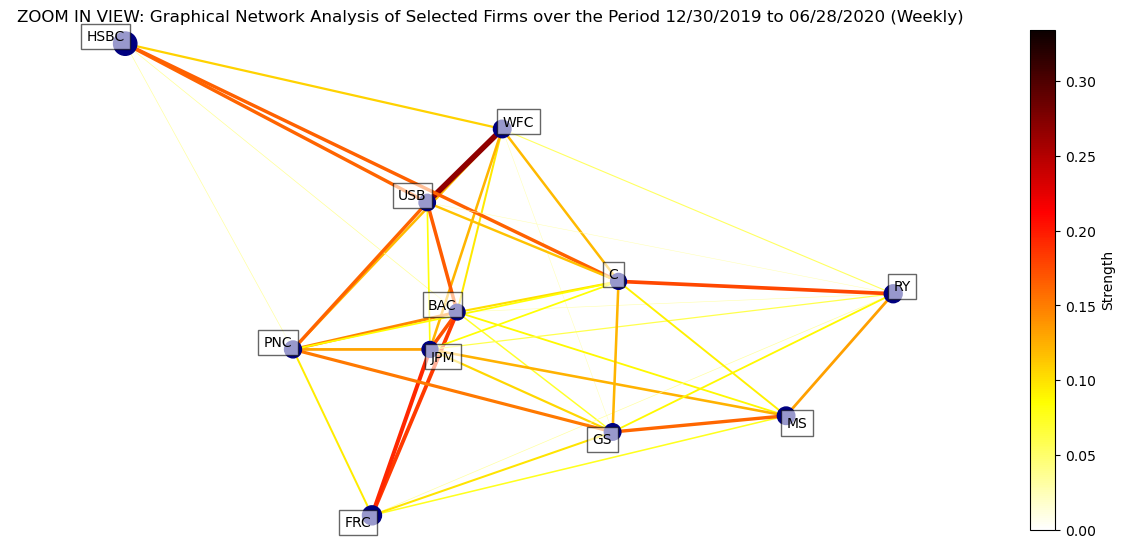

In [176]:
graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, con_fig)

In [178]:
## The list of firms we want to look at more closely
# Note: These firms don't have to be from the same sector 
# (but they need to be in the "Sectors_chosen" list if "Sectors_chosen" is different from default setting)

firms_list = ['FRC','JPM','BAC', 'GS', 'MS', 'PNC','C']

ZOOM IN View of the Selected Firms:
['FRC', 'JPM', 'BAC', 'GS', 'MS', 'PNC', 'C']


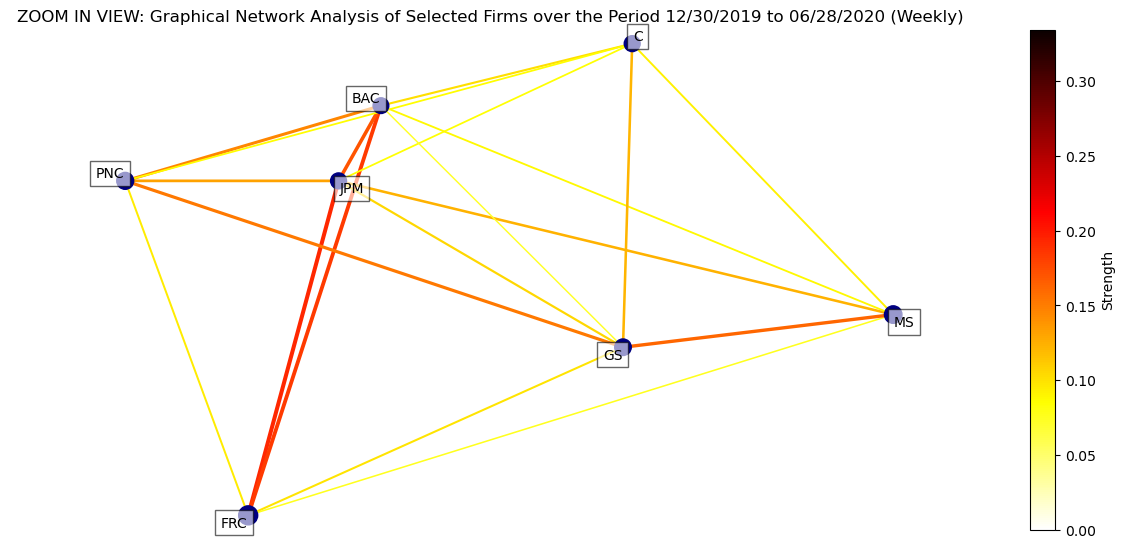

In [180]:
print('ZOOM IN View of the Selected Firms:')
print(firms_list)
graphicalAnalysis_plot_ZOOM_byFirm(firms_list, con_fig)

# Second Data Analysis
By specifying `start_date` and `end_date`, optional sectors in `Sectors_chosen`, firms to exclude in `drop_firm`, and default settings for displaying summary statistics (`display_SumStat=True`) and individual firm performance (`display_IndRet=True`), the graphical analysis can be tailored to analyze selected sectors, exclude specific firms, and visualize performance over a given period.

In [184]:
## Start and End date we are considering:
start_date = '2015-07-01'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank','Health','Energy','Tech']

## The list of firms we want to drop:
drop_firm = []

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = True
display_IndRet = True

Results over the time period  2015-07-01  to  2020-06-28 :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Number of firms examined: 22
Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL, GOOG, MSFT
Cluster 5: BABA


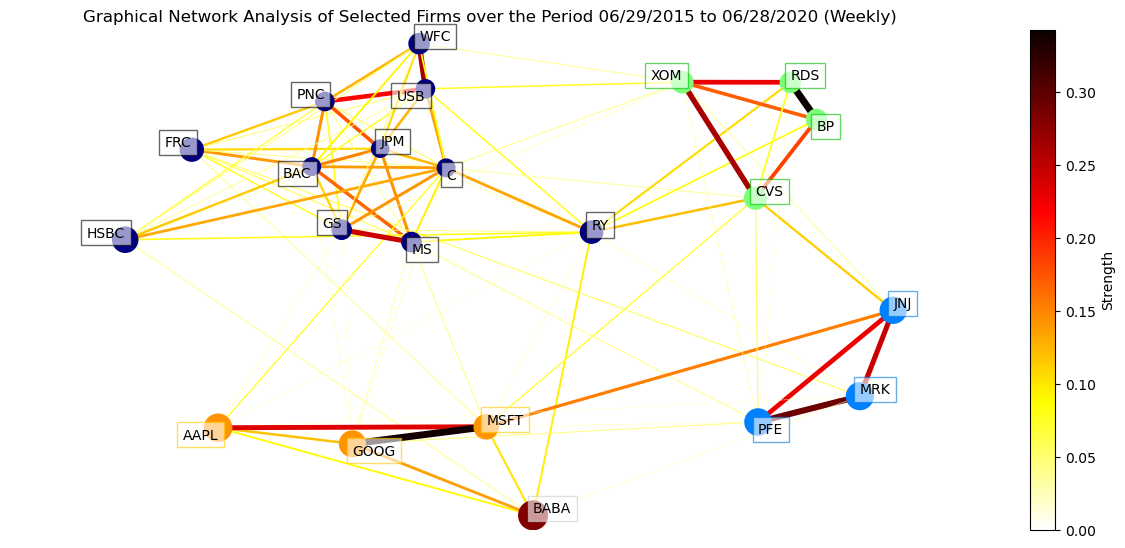

Individual Stock Performance over the Period 06/29/2015 to 06/28/2020 (Weekly):


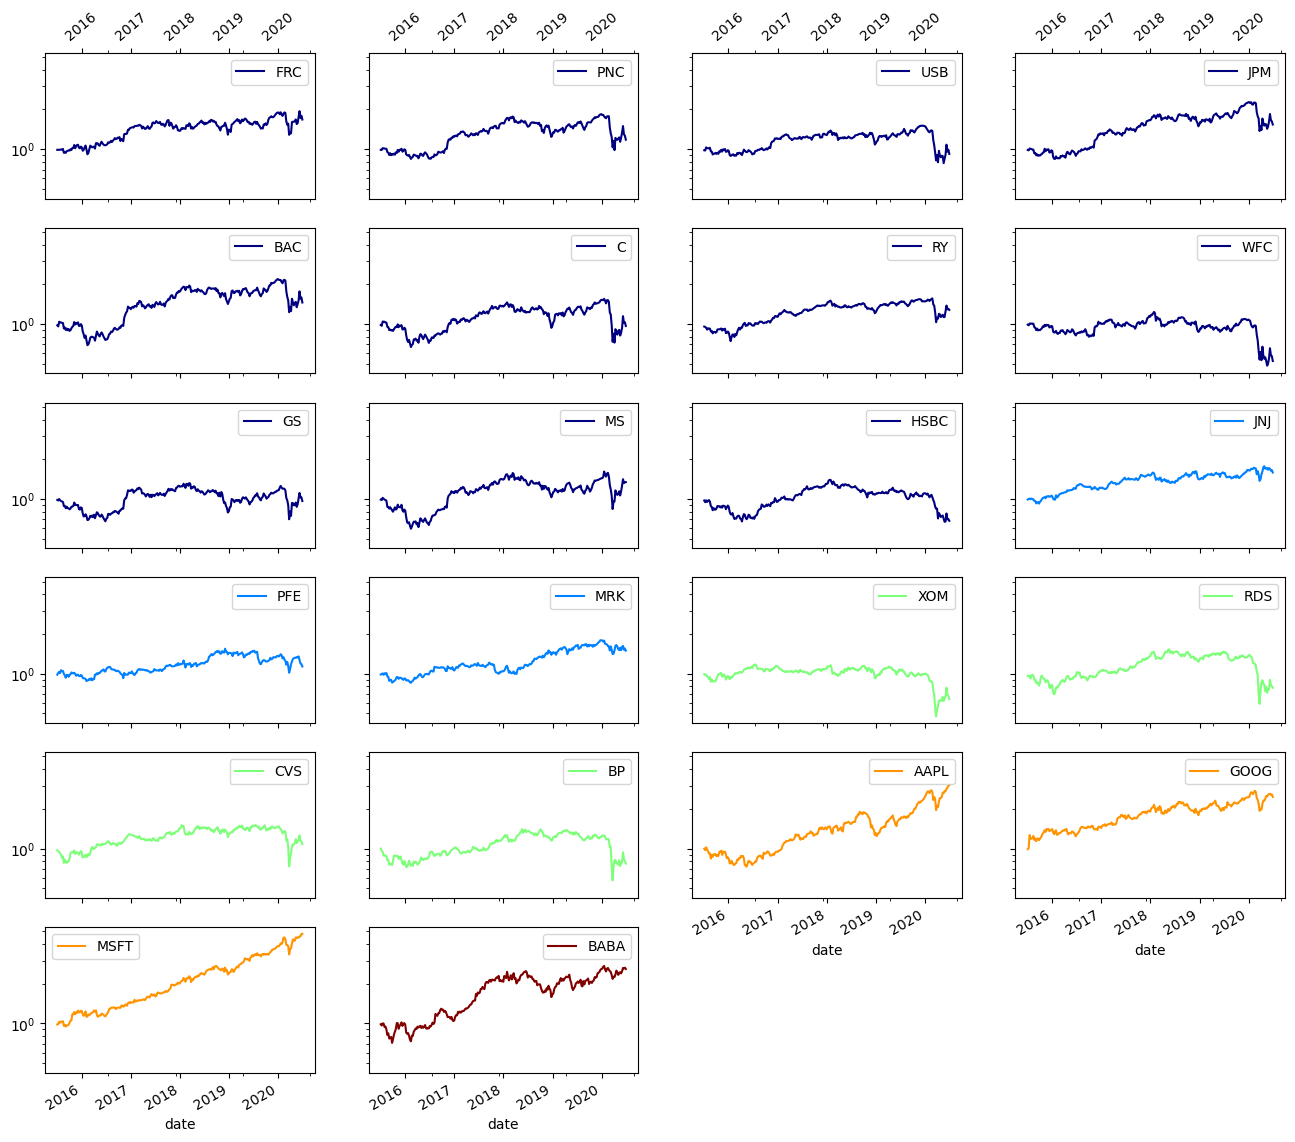

Summary Statistic Information from 06/29/2015 to 06/28/2020:


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
FRC,Bank,67.82,0.28,15.53,28.84,0.55,-32.56
PNC,Bank,17.99,0.15,7.95,29.49,0.28,-46.63
USB,Bank,-8.02,0.04,2.12,27.53,0.09,-48.13
JPM,Bank,53.80,0.24,13.29,27.99,0.48,-39.64
BAC,Bank,45.63,0.25,13.99,33.62,0.44,-43.98
C,Bank,-3.41,0.11,5.84,35.61,0.17,-53.47
RY,Bank,27.91,0.14,7.31,20.63,0.32,-34.02
WFC,Bank,-47.63,-0.15,-7.47,32.16,-0.22,-60.90
GS,Bank,-3.73,0.08,4.29,31.69,0.14,-46.94
MS,Bank,33.91,0.22,11.85,32.89,0.32,-48.07


In [186]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()
est, con_fig = graphicalAnalysis(data, start_date, end_date, 
                                 Sectors_chosen, drop_firm, 
                                 display_SumStat, display_IndRet)

In [188]:
## The list of Sector(s) we want to look at more closely:
Sectors_list = ['Bank']

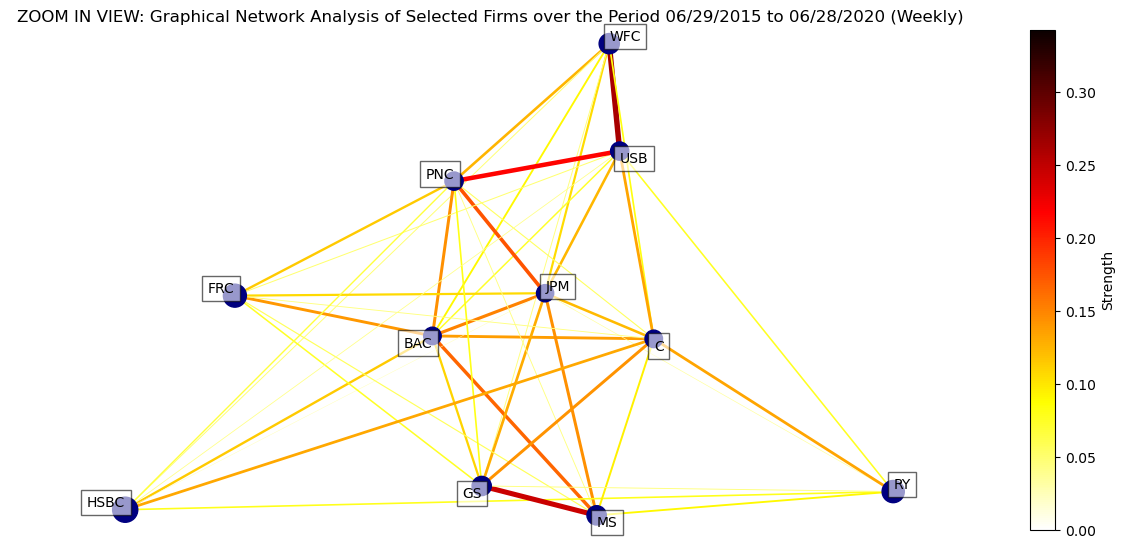

In [190]:
graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, con_fig)

In [192]:
firms_list = ['FRC','PNC','USB','BAC', 'GS','JPM','C','MS']

ZOOM IN View of the Selected Firms:
['FRC', 'PNC', 'USB', 'BAC', 'GS', 'JPM', 'C', 'MS']


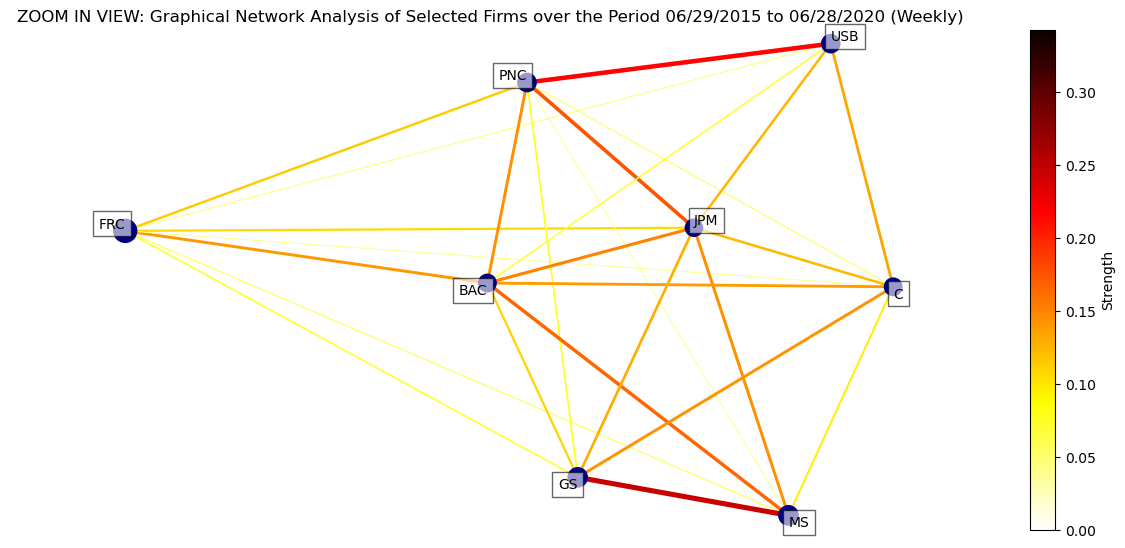

In [194]:
print('ZOOM IN View of the Selected Firms:')
print(firms_list)
graphicalAnalysis_plot_ZOOM_byFirm(firms_list, con_fig)

# Single Stock Analysis

In [197]:
firm_name = 'FRC'

In [199]:
# Output the index (or date) of the first datapoint for given firm's returns
data[firm_name].first_valid_index()

Timestamp('2010-12-12 00:00:00')

In [201]:
## Start and End date we are considering:
start_date = '2010-12-12'
end_date   = '2020-06-28'

## Sectors which we will be testing:
Sectors_chosen = ['Bank','Health','Energy','Tech']

## The list of firms we want to drop:
drop_firm = []

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = True
display_IndRet = True

Graphical analysis results over the time period  2010-12-12  to  2020-06-28  for  FRC :

Sectors choosen in the Graphical Analysis are:
['Bank', 'Health', 'Energy', 'Tech']

Dropping firms: 
BABA

Number of firms examined: 21
Cluster 1: FRC, PNC, USB, JPM, BAC, C, RY, WFC, GS, MS, HSBC
Cluster 2: JNJ, PFE, MRK
Cluster 3: XOM, RDS, CVS, BP
Cluster 4: AAPL
Cluster 5: GOOG, MSFT


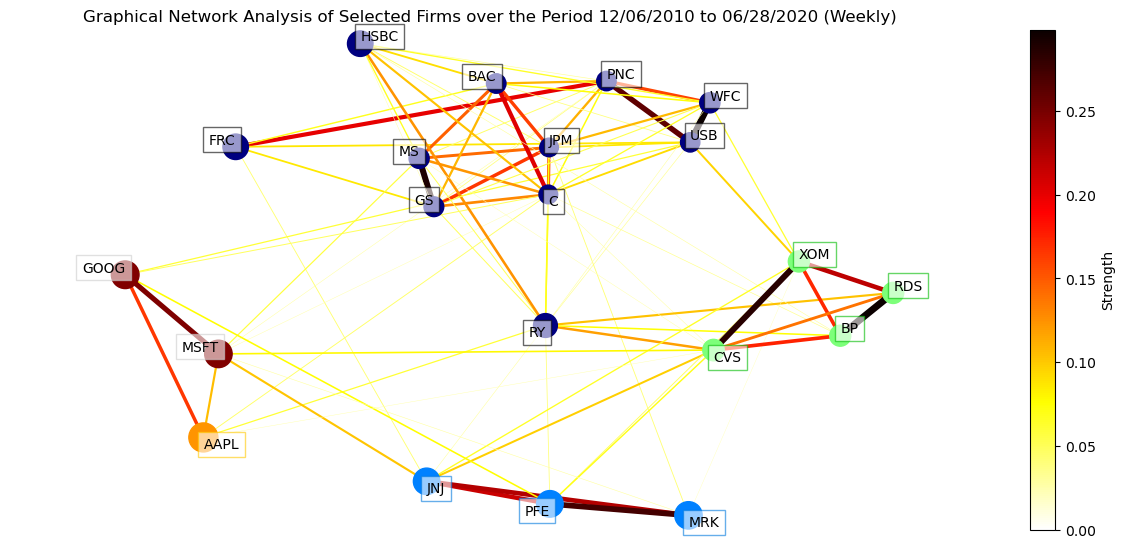

Individual Stock Performance over the Period 12/06/2010 to 06/28/2020 (Weekly):


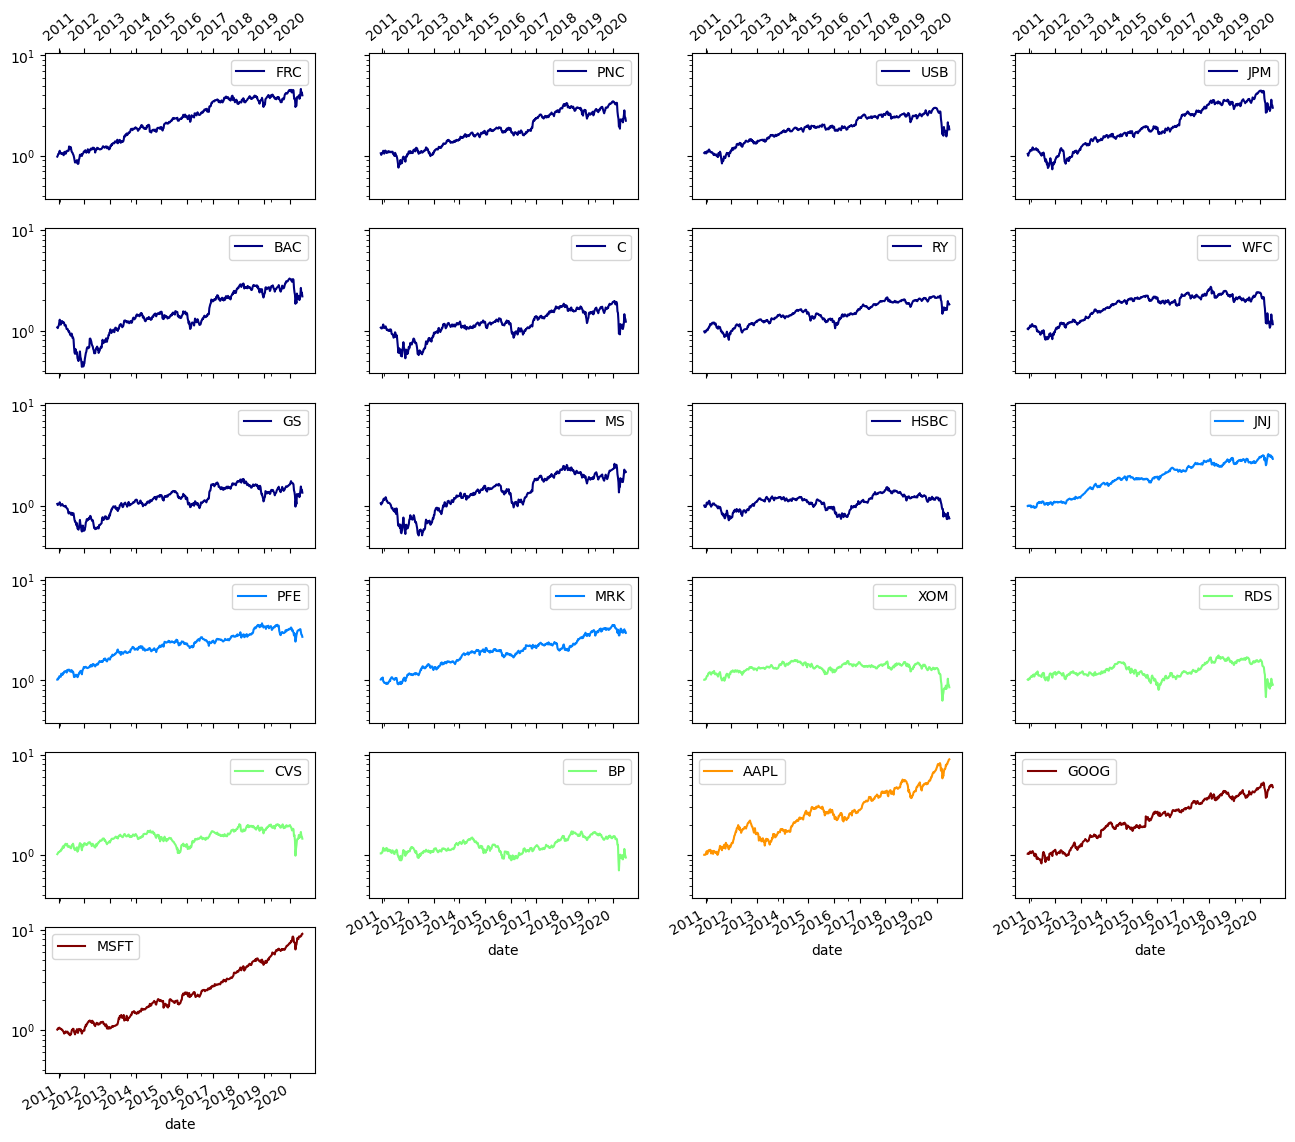

Summary Statistic Information from 12/06/2010 to 06/28/2020:


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Annu. Sharpe Ratio,Max Drawdown(%)
FRC,Bank,299.96,0.34,19.47,25.94,0.76,-33.06
PNC,Bank,123.35,0.23,12.51,26.13,0.49,-46.63
USB,Bank,83.36,0.18,9.65,24.16,0.41,-48.13
JPM,Bank,200.97,0.29,16.23,26.72,0.61,-39.64
BAC,Bank,119.38,0.27,14.75,33.53,0.45,-66.00
C,Bank,22.89,0.16,8.42,34.47,0.25,-53.90
RY,Bank,82.56,0.16,8.62,19.95,0.41,-35.26
WFC,Bank,15.97,0.10,5.29,26.96,0.21,-60.90
GS,Bank,34.27,0.14,7.52,29.02,0.26,-48.89
MS,Bank,116.13,0.26,14.68,33.70,0.41,-58.41


In [203]:
print('Graphical analysis results over the time period ', start_date, ' to ', end_date, ' for ', firm_name, ':')
print()
est, con_fig = graphicalAnalysis(data, start_date, end_date, 
                                 Sectors_chosen, drop_firm, 
                                 display_SumStat, display_IndRet)

In [205]:
## The list of Sector(s) we want to look at more closely
Sectors_list = ['Bank']

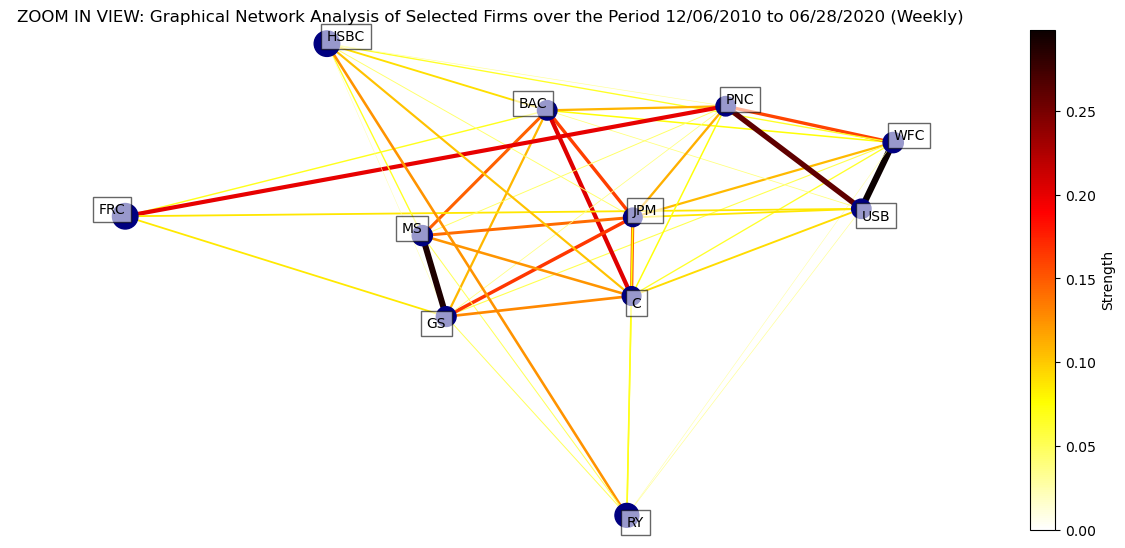

In [207]:
graphicalAnalysis_plot_ZOOM_bySector(Sectors_list, con_fig)

In [209]:
## The list of firms we want to look at more closely
# Note: These firms don't have to be from the same sector
firms_list = ['FRC','PNC', 'USB', 'BAC', 'GS']

ZOOM IN View of the Selected Firms:
['FRC', 'PNC', 'USB', 'BAC', 'GS']


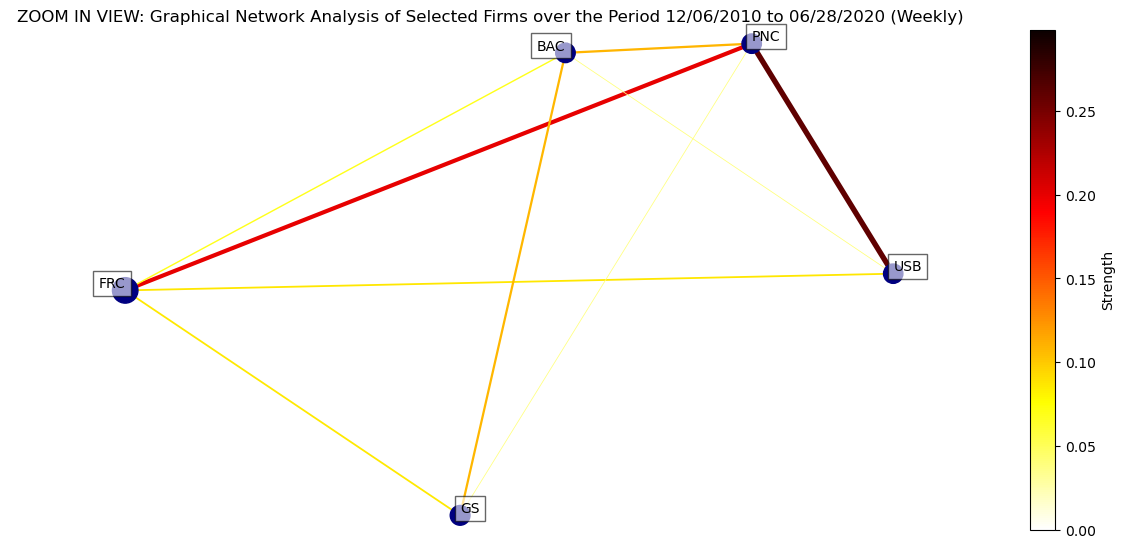

In [211]:
print('ZOOM IN View of the Selected Firms:')
print(firms_list)
graphicalAnalysis_plot_ZOOM_byFirm(firms_list, con_fig)